In [1]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#dataset notes discovered
     # aspect layer has -9999 at all the lakes

### Create DataFrame for Multiple Linear Regression

In [3]:
msk_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_msk_20m.asc'
dem_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_dem_20m.asc'
asp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_asp_20m.asc'
slp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_slp_20m.asc'

dep_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/ascii/20160426_SUPERsnow_depth_20m.asc' #just one depth image...
years = list(range(2013, 2019))

In [4]:
#open
msk_ = np.loadtxt(msk_20m_path, skiprows=6)
dem_ = np.loadtxt(dem_20m_path, skiprows=6)
asp_ = np.loadtxt(asp_20m_path, skiprows=7) 
slp_ = np.loadtxt(slp_20m_path, skiprows=7) 
dep_ = np.loadtxt(dep_20m_path, skiprows=7) / 10                      #convert mm to cm

In [5]:
#flatten
msk = msk_.flatten()
dem = dem_.flatten()
asp = asp_.flatten()
slp = slp_.flatten()
dep = dep_.flatten()

In [6]:
#filters: (1) Tuolumne Basin, (2) Snow Covered Areas, (3) No Data Values for Aspect, -9999
dem = dem[(msk==1) & (dep>0)]
asp = asp[(msk==1) & (dep>0)]
slp = slp[(msk==1) & (dep>0)] 
dep = dep[(msk==1) & (dep>0)]

In [7]:
#size check
print(dem.size)
print(asp.size)
print(slp.size)
print(dep.size)

2486979
2486979
2486979
2486979


In [8]:
#scatter plots.....to show dependent variable's correlation with independent variable


In [9]:
#dataframe
d = {'dep': dep, 'dem': dem, 'asp': asp, 'slp': slp}                 #data to be put in df
df_ = pd.DataFrame(d)                                                #create df
df = df_.dropna()                                                    #remove all rows with any NaN's
df.drop(df[df['asp'] < 0].index, inplace=True)                       #remove all -9999 in aspect values (i.e. the lakes, water bodies)
df.head()                                                            #shows first 5 rows of df

,dep,dem,asp,slp
0,100.5,3173.589355,231.494385,2.798378
1,44.1,3174.205078,224.230560,2.318916
2,142.0,3174.610107,277.199219,0.770132
3,152.5,3172.035645,199.983109,3.083293
4,118.1,3172.527100,218.970459,4.072806


In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)           #float value to the hundredths place
df.describe()                                                         #summary stats, 50%=median, note Aspect and Slope mins=0, ~2.48 million values in remaining dataset 

,dep,dem,asp,slp
count,2486231.00,2486231.00,2486231.00,2486231.00
mean,135.96,2866.75,201.33,19.01
std,92.45,328.64,98.44,11.99
min,0.10,1078.79,0.00,0.00
25%,68.10,2653.10,121.60,9.44
50%,126.50,2876.96,209.88,17.01
75%,188.30,3081.61,288.27,26.80
max,1265.20,3984.03,360.00,76.27


### Multiple Linear Regression
- independent variable = snow depth [cm]
- dependent variables = (1) Elevation [m], (2) Aspect [degrees], (3) Slope [degrees]

In [11]:
#set up training and testing dataset
X = df.iloc[:,df.columns != 'dep']                                                        #all dependent variables, excludes snow depth
Y = df.iloc[:, 0]                                                                         #independent variable
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)  #train_test_split imported from sklearn.model_selection

#ASK HP ABOUT RANDOM_STATE and what it means for the random seed: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)                                                               #train the model with 20% of the data (20% set in above cell)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
dem,0.11
asp,0.01
slp,-0.51


In [14]:
y_pred = model.predict(X_test)

In [15]:
mod_df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
mod_df

,Actual,Predicted
1434712,127.10,99.68
1685876,54.40,57.92
1020530,6.70,99.77
1075598,71.00,112.89
1207515,208.00,147.86
...,...,...
962532,365.10,171.04
951101,172.30,143.09
427773,131.00,110.67
252836,61.20,108.83


(0, 500)

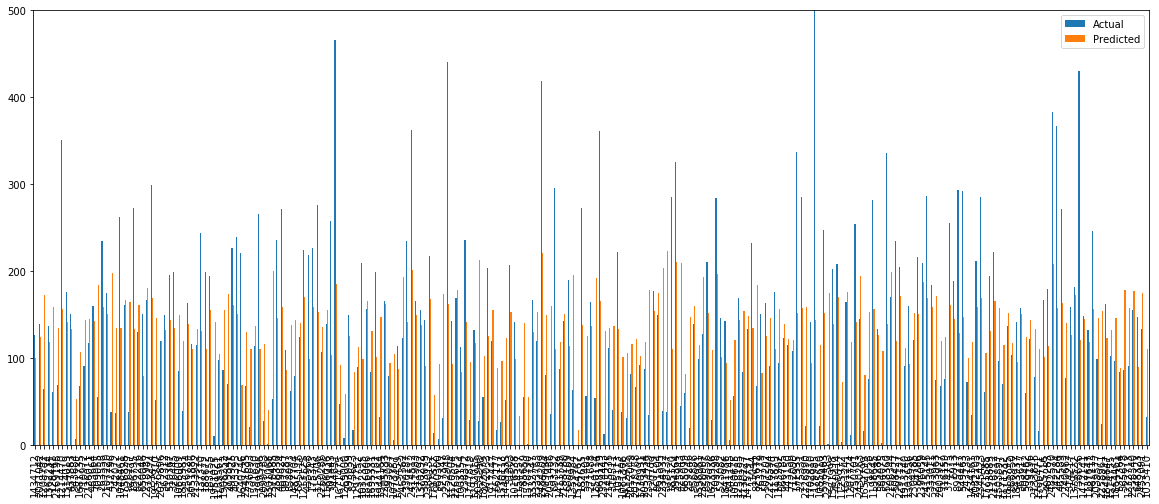

In [16]:
mod_df[::5000].plot(kind='bar', figsize=(20,8)) #every 5000th value
plt.ylim(0,500)

In [17]:
mod_df

,Actual,Predicted
1434712,127.10,99.68
1685876,54.40,57.92
1020530,6.70,99.77
1075598,71.00,112.89
1207515,208.00,147.86
...,...,...
962532,365.10,171.04
951101,172.30,143.09
427773,131.00,110.67
252836,61.20,108.83


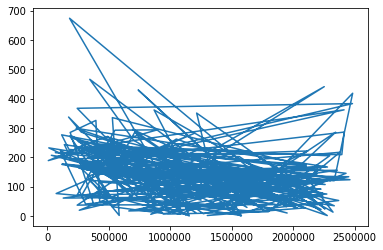

In [18]:
mod_df['Actual'][::5000].plot()

In [19]:
break

SyntaxError: 'break' outside loop (<ipython-input-19-6aaf1f276005>, line 4)

#### TEST STUFF HERE

In [ ]:
#mini example

#np array
a1_ = np.random.random((4,4))
a2_ = np.random.random((4,4))
a3_ = np.random.random((4,4))
a4_ = np.random.random((4,4))

#flatten
a1 = a1_.flatten()
a2 = a2_.flatten()
a3 = a3_.flatten()
a4 = a4_.flatten()

#give it some nans
a1.ravel()[np.random.choice(a1.size, 3, replace=False)] = np.nan
a2.ravel()[np.random.choice(a2.size, 3, replace=False)] = np.nan
a3.ravel()[np.random.choice(a3.size, 3, replace=False)] = np.nan
a4.ravel()[np.random.choice(a4.size, 3, replace=False)] = np.nan

#make it a dataframe
d = {'col1': a1, 'col2': a2, 'col3': a3, 'col4': a4}
df = pd.DataFrame(d)
df



In [ ]:
ddf = df.dropna()
ddf.describe()

### could use

In [ ]:
#filter-1, Tuolumne Basin
dem = np.where(msk==1, dem, np.nan)
asp = np.where(msk==1, asp, np.nan)
slp = np.where(msk==1, slp, np.nan)
dep = np.where(msk==1, dep, np.nan)

#filter-2, Snow Covered Areas
dem = np.where(dep>0, dem, np.nan)
asp = np.where(dep>0, asp, np.nan)
slp = np.where(dep>0, slp, np.nan)
dep = np.where(dep>0, dep, np.nan)

In [ ]:
#count the number with a condition
sum(1 for i in asp if i < 0) #number of values <0 in aspect